# Сборный проект-2.  Целесообразность новых шрифтов в приложении продуктов питания.



## Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go

## Предобработка данных

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Приведем названия колонок к необходимому стилю:

In [5]:
data.columns = data.columns.str.lower()
data.head()

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
data = data.rename(columns = {'eventname': 'event_name', 'deviceidhash': 'device_id_hash', 'eventtimestamp': 'event_timestamp', 'expid': 'exp_id'})
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим датасет на наличие дубликатов:

In [7]:
data.duplicated().sum()

413

Найдено 413 дубликатов.

Так же проверим датасет на наличие пропусков:

In [8]:
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

Так как количество дубликатов составляет малую часть данных, избавимся от них:

In [9]:
data = data.drop_duplicates().reset_index()
data.duplicated().sum()

0

Приведем данные с временем и датой к нужному типу:

In [10]:
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_date'] = pd.to_datetime(data['event_datetime']).dt.date.astype('datetime64[ns]')
data.head()

,index,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            243713 non-null  int64         
 1   event_name       243713 non-null  object        
 2   device_id_hash   243713 non-null  int64         
 3   event_timestamp  243713 non-null  int64         
 4   exp_id           243713 non-null  int64         
 5   event_datetime   243713 non-null  datetime64[ns]
 6   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 13.0+ MB


Благодаря предобоработке, были исправлены названия стобцов на подходящие по стилю и исправлены типы данных на необходимые. Так же датасет был очищен от дубликатов. Пропусков найдено не было.

Проверим, не попали ли у нас одни и те же пользователи в разные группы:

In [12]:
data_246 = data.query('exp_id == "246"')
data_247 = data.query('exp_id == "247"')
data_248 = data.query('exp_id == "248"')
data_orders_cross_246_247 = data_246.merge(data_247, on='device_id_hash')['device_id_hash'].unique()
print('Пересекающихся пользователей между 246ой и 247ой группами:', len(data_orders_cross_246_247))
data_orders_cross_246_248 = data_246.merge(data_248, on='device_id_hash')['device_id_hash'].unique()
print('Пересекающихся пользователей между 246ой и 248ой группами:', len(data_orders_cross_246_248))
data_orders_cross_247_248 = data_247.merge(data_248, on='device_id_hash')['device_id_hash'].unique()
print('Пересекающихся пользователей между 247ой и 248ой группами:', len(data_orders_cross_247_248))

Пересекающихся пользователей между 246ой и 247ой группами: 0
Пересекающихся пользователей между 246ой и 248ой группами: 0
Пересекающихся пользователей между 247ой и 248ой группами: 0


## Изучение и проверка данных:

Узнаем количество событий в логах:

In [13]:
print('Количество событий в логах:', data['event_name'].nunique())

Количество событий в логах: 5


Узнаем количество уникальных пользователей в логах:

In [14]:
print('Количество уникальных пользователей в логах:', data['device_id_hash'].nunique())

Количество уникальных пользователей в логах: 7551


Узнаем сколько в среднем событий приходится на пользователя:

In [15]:
print('В среднем событий приходится на пользователя:', round(data['event_name'].count() / data['device_id_hash'].nunique(), 2))

В среднем событий приходится на пользователя: 32.28


Узнаем, данными за какой период мы располагаем.

Найдем максимальную и минимальную дату:

In [16]:
data['event_datetime'].min()

Timestamp('2019-07-25 04:43:36')

In [17]:
data['event_datetime'].max()

Timestamp('2019-08-07 21:15:17')

Построим гистограмму по дате и времени:

In [18]:
plt.rcParams ['figure.figsize'] = [10, 7] # Увеличили графики во всем проекте.

<AxesSubplot:title={'center':'Гистограмма по дате и времени'}, xlabel='Дата', ylabel='События'>

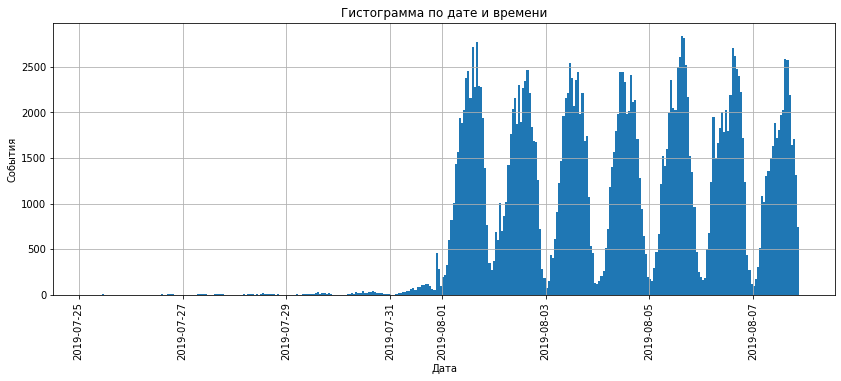

In [19]:
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата')
plt.ylabel('События')
plt.xticks(rotation=90)
data['event_datetime'].hist(bins=14*24, figsize=(14, 5))

<AxesSubplot:>

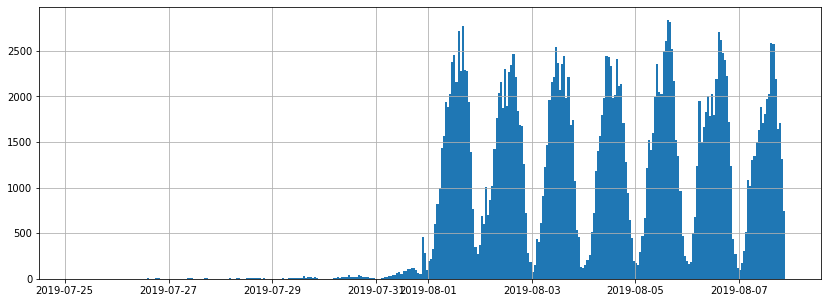

In [20]:
# код ревьюера
data['event_datetime'].hist(bins=14*24, figsize=(14, 5))

Посмотрим на количество событий по дням:

In [21]:
logs_daily = data.groupby(by='event_date').agg({'event_name': 'count'}).reset_index()
logs_daily

,event_date,event_name
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


Благодаря гистограмме и полученным данным можно утверждать, что мы располагаем полными данными только за период с 2019-08-01 по 2019-08-07.

Отфильтруем исходный датасет:

In [22]:
data_filtered = data.query('event_datetime >= "2019-08-01 00:00:00"')
data_filtered.head()

,index,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2826,2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Узнаем какое количество событий было отброшено:

In [23]:
print('Количество событий до:', len(data), 'Количество событий после:', len(data_filtered), 'Количество отброшенных событий:', len(data) - len(data_filtered))

Количество событий до: 243713 Количество событий после: 240887 Количество отброшенных событий: 2826


In [24]:
print('Количество пользователей до:', data['device_id_hash'].nunique(), 'Количество пользователей после:', data_filtered['device_id_hash'].nunique(), 'Количество отброшенных пользователей:', data['device_id_hash'].nunique() - data_filtered['device_id_hash'].nunique())

Количество пользователей до: 7551 Количество пользователей после: 7534 Количество отброшенных пользователей: 17


In [25]:
print('Событий потеряно:', round(len(data['event_name']) / len(data_filtered['event_name'])), '%')

Событий потеряно: 1 %


In [26]:
print('Пользователей потеряно', round(data['device_id_hash'].nunique() / data_filtered['device_id_hash'].nunique()), '%')


Пользователей потеряно 1 %


Количество отброшенных событий: 2826. Количество отброшенных пользователей: 17. Событий потеряно: 1 %. Пользователей потеряно 1 %
. Благодаря полученным данным ясно, что был отброшен незначительный их объем.

Проверим, что у нас есть все пользователи из трех экспериментальных групп:

In [27]:
data_filtered.groupby('exp_id').agg({'device_id_hash': 'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


## Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [28]:
data_events = data_filtered.value_counts('event_name').reset_index()
data_events.columns = ['event_name', 'logs']
data_events

,event_name,logs
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Посчитаем, сколько пользователей совершали каждое из событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [29]:
data_users = data_filtered.groupby('event_name').agg({'device_id_hash':'nunique'}).sort_values('device_id_hash', ascending=False)
data_users = data_events.merge(data_users, on = 'event_name')
data_users.columns = ['event_name', 'event_count', 'users_count']
data_users

,event_name,event_count,users_count
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


In [30]:
data_users['users_count/users_all'] = (data_users['users_count'] / data.device_id_hash.nunique())
data_users.style.format({'users_count/users_all': '{:.2%}'})

,event_name,event_count,users_count,users_count/users_all
0,MainScreenAppear,117328,7419,98.25%
1,OffersScreenAppear,46333,4593,60.83%
2,CartScreenAppear,42303,3734,49.45%
3,PaymentScreenSuccessful,33918,3539,46.87%
4,Tutorial,1005,840,11.12%


Чаще всего пользователи переходят на страницу главного экрана, однако полтора процента пользователей в приложение не заходят. Далее события выстраиваются в последовательную цепочку. Туториал скорее всего явлется опциональной функцией и пропускается большинством пользователей.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки:

In [31]:
data_users['steps_conversion'] = (data_users['users_count'].pct_change().fillna(0)+1)
data_users.style.format({'users_count/users_all': '{:.2%}', 'steps_conversion': '{:.2%}'})

,event_name,event_count,users_count,users_count/users_all,steps_conversion
0,MainScreenAppear,117328,7419,98.25%,100.00%
1,OffersScreenAppear,46333,4593,60.83%,61.91%
2,CartScreenAppear,42303,3734,49.45%,81.30%
3,PaymentScreenSuccessful,33918,3539,46.87%,94.78%
4,Tutorial,1005,840,11.12%,23.74%


По таблице видно, что большая часть пользователей теряется на шаге перехода с главного экарна на экран с предложениями - 37.42%. От первого события до успешной оплаты доходит 46.87% пользователей.

Построим воронку для наглядной визуализации конверсии:

In [42]:
fig = go.Figure(go.Funnel(
    y = data_users['event_name'],
    x = round(data_users['users_count/users_all'], 2)))

fig.show()

## Изучение результатов эксперимента

Узнаем сколько пользователей в каждой экспериментальной группе и добавим две объединенные 246 и 247 группы:

In [33]:
data_exp = data_filtered.groupby('exp_id').agg({'device_id_hash':'nunique'}).sort_values('device_id_hash').reset_index()
data_exp_2 = data_exp['device_id_hash']
data_exp.loc[3] = ['246+247', data_exp_2[0]+data_exp_2[1]]
data_exp = data_exp.set_index(data_exp.columns[0])
data_exp

,device_id_hash
exp_id,
246,2484
247,2513
248,2537
246+247,4997


Создадим датасет с разбивкой по количеству пользователей в каждой группе, на каждое уникальное событие. Так же удалим туториал, являющийся необязательным:

In [34]:
data_funnels = data_filtered.pivot_table(index='event_name', values='device_id_hash', columns='exp_id', aggfunc='nunique').sort_values(246, ascending=False)
data_funnels['246+247'] = data_funnels[246] + data_funnels[247]
data_funnels.drop(['Tutorial'], inplace=True)
data_funnels

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


Сформулируем гипотезы: 

Н0 - Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

Н1 - Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

Для проверки гипотез воспользуемся z-тестом с использованием поправки Бонферрони, из-за проведения множественных сравнений. Так как сравнений будет 16, alpha = alpha/16.  Для удобства обернем z-тест в функцию:

In [35]:
alpha = .05 # критический уровень статистической значимости

def z_test(exp_1, exp_2, event, alpha): 
    p1_event = data_funnels.loc[event, exp_1]
    p2_event = data_funnels.loc[event, exp_2] 
    p1_users = data_exp.loc[exp_1, 'device_id_hash'] 
    p2_users = data_exp.loc[exp_2, 'device_id_hash'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    alpha = alpha / 16
    
    print('Проверяем группы {} и {}, событие: {}, p-value = {p_value:.2f}'.format(exp_1, exp_2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не можем отвергнуть нулевую гипотезу")


Проверим, находят ли статистические критерии разницу между выборками 246 и 247:

In [36]:
for event in data_funnels.index:
    z_test(246, 247, event, 0.05)
    print()

Проверяем группы 246 и 247, событие: MainScreenAppear, p-value = 0.76
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246 и 247, событие: OffersScreenAppear, p-value = 0.25
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246 и 247, событие: CartScreenAppear, p-value = 0.23
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246 и 247, событие: PaymentScreenSuccessful, p-value = 0.11
Не можем отвергнуть нулевую гипотезу



Конверсия в обеих группах по каждому событию равна.

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие:

In [37]:
data_popular = data_filtered.pivot_table(index='event_name', values='device_id_hash', columns='exp_id', aggfunc='nunique').reset_index()
data_popular.columns = ['event_name', 246, 247, 248]
data_popular['conversion_246(%)'] = round((data_popular[246] / data_exp.device_id_hash[246] * 100), 2)
data_popular['conversion_247(%)'] = round((data_popular[247] / data_exp.device_id_hash[247] * 100), 2)
data_popular['conversion_248(%)'] = round((data_popular[248] / data_exp.device_id_hash[248] * 100), 2)
data_popular = data_popular.sort_values(246, ascending=False).reset_index(drop=True)
data_popular = data_popular.drop([4])
data_popular

,event_name,246,247,248,conversion_246(%),conversion_247(%),conversion_248(%)
0,MainScreenAppear,2450,2476,2493,98.63,98.53,98.27
1,OffersScreenAppear,1542,1520,1531,62.08,60.49,60.35
2,CartScreenAppear,1266,1238,1230,50.97,49.26,48.48
3,PaymentScreenSuccessful,1200,1158,1181,48.31,46.08,46.55


Самым популярным событием является переход на главный экран. Число пользователей, совершивших это событие в группе 246: 2450, в группе 247: 2476, в группе 248: 2493. Доля пользователей, совершивших это событие в группе 246: 98.63%, в группе 247: 98.53%, в группе 248: 98.27%.

Проверим, находят ли статистические критерии разницу между выборками 246 и 248:

In [38]:
for event in data_funnels.index:
    z_test(246, 248, event, 0.05)
    print()

Проверяем группы 246 и 248, событие: MainScreenAppear, p-value = 0.29
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246 и 248, событие: OffersScreenAppear, p-value = 0.21
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246 и 248, событие: CartScreenAppear, p-value = 0.08
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246 и 248, событие: PaymentScreenSuccessful, p-value = 0.21
Не можем отвергнуть нулевую гипотезу



Конверсия в обеих группах по каждому событию равна.

Проверим, находят ли статистические критерии разницу между выборками 247 и 248:

In [39]:
for event in data_funnels.index:
    z_test(247, 248, event, 0.05)
    print()

Проверяем группы 247 и 248, событие: MainScreenAppear, p-value = 0.46
Не можем отвергнуть нулевую гипотезу

Проверяем группы 247 и 248, событие: OffersScreenAppear, p-value = 0.92
Не можем отвергнуть нулевую гипотезу

Проверяем группы 247 и 248, событие: CartScreenAppear, p-value = 0.58
Не можем отвергнуть нулевую гипотезу

Проверяем группы 247 и 248, событие: PaymentScreenSuccessful, p-value = 0.74
Не можем отвергнуть нулевую гипотезу



Конверсия в обеих группах по каждому событию равна.

Проверим, находят ли статистические критерии разницу между объединенными выборками 246+247 и выборкой 248:

In [40]:
for event in data_funnels.index:
    z_test('246+247', 248, event, 0.05)
    print()

Проверяем группы 246+247 и 248, событие: MainScreenAppear, p-value = 0.29
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246+247 и 248, событие: OffersScreenAppear, p-value = 0.43
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246+247 и 248, событие: CartScreenAppear, p-value = 0.18
Не можем отвергнуть нулевую гипотезу

Проверяем группы 246+247 и 248, событие: PaymentScreenSuccessful, p-value = 0.60
Не можем отвергнуть нулевую гипотезу



Конверсия по каждому событию в выборках равна.

Исходя из полученных данных, можно сказать, что изменение дизайнов шрифтов никак не повлияло на пользователей.

Какой уровень значимости был выбран при проверке статистических гипотез? Посчитаем, сколько проверок статистических гипотез сделано:

При проведении эксперимента было сделано 16 проверок статистических гипотез. Был выбран стандартный уровень значимости в 0.05, с применением поправки Бонферрони.

## Вывод

В проекте была исследована конверсия пользователей для каждого уникального события в приложении и изучены результаты А/А/В тестов для контрольных групп со старым и новым типом шрифтов.

В ходе работы было выявлено, что при переходе с главного экрана на экран с предложениями, теряется 37.42% пользователей. Возможно дело в неинтуитивном интерфейсе, ведь туториал пропускает большинство пользователей. От первого события до успешной оплаты доходит 46.87% пользователей.

По результатам А/А/В тестов не было выявлено различий между экспериментальной и контрольными группами. Замена шрифтов никак не влияет на пользователей. Возможно стоит провести тест с большей выборкой.